In this section, we try to use Neural networks for the prediction Time Series.
We start from a simple Neural Network and improve it to get the best result.

# 1. Import Needed Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importing Tensorflow and Keras
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
keras = tf.keras

import warnings
warnings.filterwarnings("ignore")

W1005 14:00:17.746726  1840 __init__.py:690] 

  TensorFlow's `tf-nightly` package will soon be updated to TensorFlow 2.0.

  Please upgrade your code to TensorFlow 2.0:
    * https://www.tensorflow.org/beta/guide/migration_guide

  Or install the latest stable TensorFlow 1.X release:
    * `pip install -U "tensorflow==1.*"`

  Otherwise your code may be broken by the change.

  


# 2. Read data

In [2]:
data = pd.read_csv('Data_files/CSV/part-00000-4f161bf8-72b5-4963-84c9-7d9d786286f7-c000.csv', 
                   names = ['Date','Population', 'Consumption', 'Persevelance', 'AveragePrice'])
data.sort_index(inplace=True) 
data['Income'] = data['Population'].astype(float) * data['Consumption'].astype(float) *\
data['Persevelance'].astype(float) * data['AveragePrice'].astype(float)/20*365/10**9
data.head()

,Date,Population,Consumption,Persevelance,AveragePrice,Income
0,2008,90910000,21.2,26.4,1.07,993.569136
1,2009,92438000,21.5,27.0,1.12,1096.815694
2,2010,93966000,21.5,27.6,1.17,1190.603110
3,2011,95595000,21.4,27.0,1.20,1209.641923
4,2012,97224000,21.4,26.5,1.23,1237.659308


In [3]:
ts = data['Income'].astype(float)
time = data['Date']

In [4]:
# Splitting data on test and train
split_time = 7
time_train = time[:split_time]
x_train = ts[:split_time]
time_valid = time[split_time:]
x_valid = ts[split_time:]

# 3. First Model with 1 Dense Layer

In [5]:
# Function to put windows as an input for the algorithm
def window_dataset(series, window_size, batch_size=5,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [6]:
# Clear Session and set up Random seed
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [7]:
# Set up Window size. Window size tells how many values before predicted value we use for the prediction. 
# Do not think to use more than 2, because we have a limited amount of data
window_size = 2
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

# Initiate Sequential model with one Dense Layer 
model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

# Set up optimizer and compile the model 
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Use Early stopping to decrease overfitting
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=100,
          validation_data=valid_set,
          callbacks=[early_stopping])

W1005 14:00:19.567238  1840 deprecation.py:323] From C:\Users\ivan1\Anaconda3\lib\site-packages\tensorflow_core\python\data\util\random_seed.py:58: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
1/1 [==============================] - 1s 729ms/step - loss: 177.0335 - mae: 177.5335 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 87ms/step - loss: 166.5263 - mae: 167.0263 - val_loss: 617.0938 - val_mae: 617.5938
Epoch 3/100
1/1 [==============================] - 0s 88ms/step - loss: 154.6120 - mae: 155.1120 - val_loss: 532.0833 - val_mae: 532.5833
Epoch 4/100
1/1 [==============================] - 0s 102ms/step - loss: 146.5560 - mae: 147.0560 - val_loss: 440.4863 - val_mae: 440.9863
Epoch 5/100
1/1 [==============================] - 0s 87ms/step - loss: 137.8732 - mae: 138.3732 - val_loss: 342.9617 - val_mae: 343.4617
Epoch 6/100
1/1 [==============================] - 0s 85ms/step - loss: 141.4506 - mae: 141.9506 - val_loss: 263.6997 - val_mae: 264.1997
Epoch 7/100
1/1 [==============================] - 0s 93ms/step - loss: 145.6667 - mae: 146.1667 - val_loss: 200.8745 - val_mae: 201.3745
Epoch 8/100
1/1 [===========

We need only 13 epochs for training. It's a logical scenario because we have a too limited amount of data

In [8]:
# Create the function for forecasting 
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [9]:
# Forecasted values for 
lin_forecast = model_forecast(model, ts[split_time - window_size:-1], window_size)[:, 0]

In [10]:
# Function to plot data on the chart
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

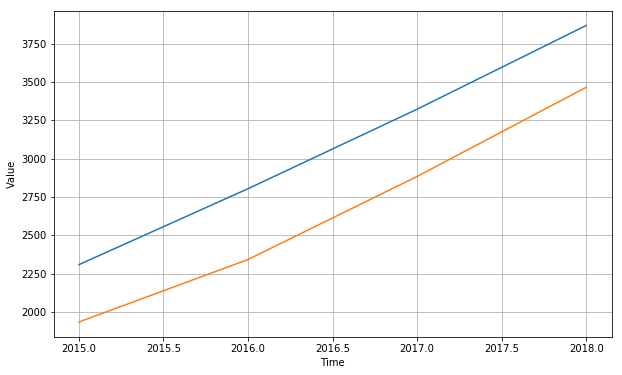

In [11]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [12]:
# Define mean absolute error for the model
keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

419.16296

# 3. Use 2 Dense layers for the model

In [13]:
# Build and train the model 
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 2
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=100,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/100
1/1 [==============================] - 1s 537ms/step - loss: 1264.3113 - mae: 1264.8113 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 97ms/step - loss: 1247.1483 - mae: 1247.6483 - val_loss: 3098.1594 - val_mae: 3098.6594
Epoch 3/100
1/1 [==============================] - 0s 87ms/step - loss: 1214.0386 - mae: 1214.5386 - val_loss: 2985.6489 - val_mae: 2986.1489
Epoch 4/100
1/1 [==============================] - 0s 91ms/step - loss: 1168.0402 - mae: 1168.5402 - val_loss: 2863.2732 - val_mae: 2863.7732
Epoch 5/100
1/1 [==============================] - 0s 88ms/step - loss: 1118.8435 - mae: 1119.3435 - val_loss: 2709.2432 - val_mae: 2709.7432
Epoch 6/100
1/1 [==============================] - 0s 94ms/step - loss: 1056.8055 - mae: 1057.3055 - val_loss: 2516.4766 - val_mae: 2516.9766
Epoch 7/100
1/1 [==============================] - 0s 96ms/step - loss: 979.2046 - mae: 979.7046 - val_loss: 2276.8340 - val_mae: 2277.3340
Epoch

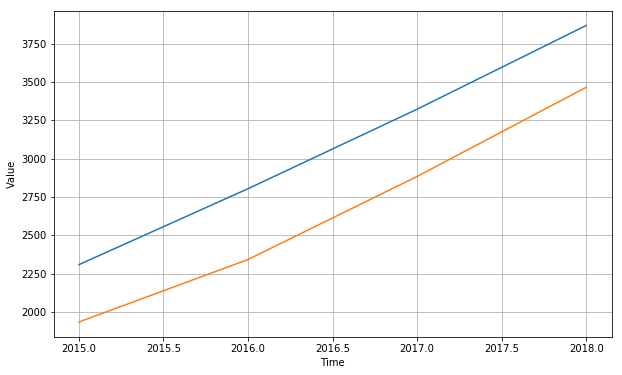

In [14]:
# Forecast data 
dense_forecast = model_forecast(
    model,
    ts[split_time - window_size:-1],
    window_size)[:, 0]
# Display data on the chart
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [15]:
# Define mean absolute error for the model
keras.metrics.mean_absolute_error(x_valid, dense_forecast).numpy()

128.17676

In [16]:
# Save the model with 2 dense layers
model.save('2_Dense.model')

W1005 14:00:27.946272  1840 deprecation.py:506] From C:\Users\ivan1\Anaconda3\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1781: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


##### Conclusion

Adding a new Dense layer improved the model MAE was 419 and become 128. So, we should use the model with 2 Dense layers.


# 4. Use simple Recurrent network for the prediction

In [17]:
# Create and train the model 
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 2
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), # 3-dimensional layer for RNN
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0) # Instead of normalizing
])
optimizer = keras.optimizers.SGD(lr=1.5e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=100,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 1468.2173 - mae: 1468.7173 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 91ms/step - loss: 1451.9133 - mae: 1452.4133 - val_loss: 3604.2671 - val_mae: 3604.7671
Epoch 3/100
1/1 [==============================] - 0s 93ms/step - loss: 1420.9070 - mae: 1421.4070 - val_loss: 3560.1929 - val_mae: 3560.6929
Epoch 4/100
1/1 [==============================] - 0s 93ms/step - loss: 1376.2539 - mae: 1376.7539 - val_loss: 3478.4492 - val_mae: 3478.9492
Epoch 5/100
1/1 [==============================] - 0s 93ms/step - loss: 1292.9340 - mae: 1293.4340 - val_loss: 3416.1204 - val_mae: 3416.6204
Epoch 6/100
1/1 [==============================] - 0s 95ms/step - loss: 1229.0544 - mae: 1229.5544 - val_loss: 3365.4233 - val_mae: 3365.9233
Epoch 7/100
1/1 [==============================] - 0s 97ms/step - loss: 1179.4747 - mae: 1179.9747 - val_loss: 3267.5720 - val_mae: 3268.0720
Epoch 

1/1 [==============================] - 0s 88ms/step - loss: 215.5452 - mae: 216.0452 - val_loss: 2310.9680 - val_mae: 2311.4680
Epoch 60/100
1/1 [==============================] - 0s 102ms/step - loss: 212.9019 - mae: 213.4019 - val_loss: 2324.2527 - val_mae: 2324.7527
Epoch 61/100
1/1 [==============================] - 0s 87ms/step - loss: 210.2449 - mae: 210.7449 - val_loss: 2337.5996 - val_mae: 2338.0996
Epoch 62/100
1/1 [==============================] - 0s 88ms/step - loss: 207.5756 - mae: 208.0756 - val_loss: 2351.0017 - val_mae: 2351.5017
Epoch 63/100
1/1 [==============================] - 0s 110ms/step - loss: 204.8951 - mae: 205.3951 - val_loss: 2364.4539 - val_mae: 2364.9539
Epoch 64/100
1/1 [==============================] - 0s 85ms/step - loss: 205.2240 - mae: 205.7240 - val_loss: 2375.1580 - val_mae: 2375.6580
Epoch 65/100
1/1 [==============================] - 0s 96ms/step - loss: 207.3649 - mae: 207.8649 - val_loss: 2383.3904 - val_mae: 2383.8904
Epoch 66/100
1/1 [======

In [18]:
# Forecasting 
rnn_forecast = model_forecast(
    model,
    ts[split_time - window_size:-1],
    window_size)[:, 0]

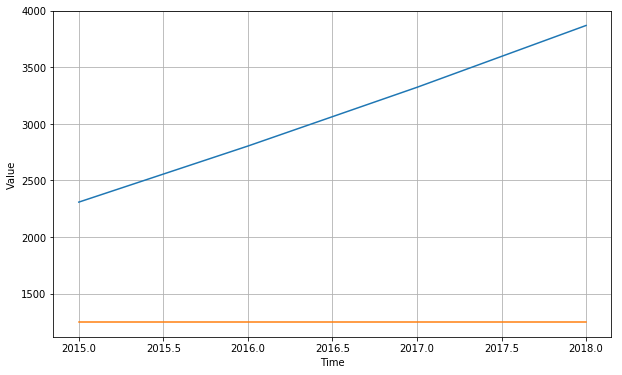

In [19]:
# Draw charts
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [20]:
# Define the the error
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1824.6292

So, MAE is the worst from all models on Neural Networks. 
So, We should not continue with RNN. Even the first implementation give us not good results

# 5. Use Strateful RNN

In [21]:
# Dataset Function
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [22]:
# Class to Reset the model before every epoch 
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [23]:
# Create the model 
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 2
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, reset_states])

Epoch 1/500
3/3 [==============================] - 3s 918ms/step - loss: 1189.2194 - mae: 1189.7194 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/500
3/3 [==============================] - 0s 30ms/step - loss: 1172.5341 - mae: 1173.0342 - val_loss: 2906.1011 - val_mae: 2906.6011
Epoch 3/500
3/3 [==============================] - 0s 28ms/step - loss: 1164.0338 - mae: 1164.5338 - val_loss: 2894.8960 - val_mae: 2895.3960
Epoch 4/500
3/3 [==============================] - 0s 30ms/step - loss: 1152.8511 - mae: 1153.3511 - val_loss: 2881.3076 - val_mae: 2881.8076
Epoch 5/500
3/3 [==============================] - 0s 31ms/step - loss: 1139.7192 - mae: 1140.2191 - val_loss: 2865.9980 - val_mae: 2866.4980
Epoch 6/500
3/3 [==============================] - 0s 29ms/step - loss: 1125.1746 - mae: 1125.6746 - val_loss: 2849.4460 - val_mae: 2849.9460
Epoch 7/500
3/3 [==============================] - 0s 29ms/step - loss: 1109.6110 - mae: 1110.1110 - val_loss: 2832.0017 - val_mae: 2832.5017
Epo

Epoch 59/500
3/3 [==============================] - 0s 34ms/step - loss: 251.5658 - mae: 252.0658 - val_loss: 1910.8499 - val_mae: 1911.3499
Epoch 60/500
3/3 [==============================] - 0s 31ms/step - loss: 236.3736 - mae: 236.8736 - val_loss: 1894.8789 - val_mae: 1895.3789
Epoch 61/500
3/3 [==============================] - 0s 28ms/step - loss: 221.2015 - mae: 221.7015 - val_loss: 1878.9371 - val_mae: 1879.4371
Epoch 62/500
3/3 [==============================] - 0s 34ms/step - loss: 206.0479 - mae: 206.5479 - val_loss: 1863.0237 - val_mae: 1863.5237
Epoch 63/500
3/3 [==============================] - 0s 30ms/step - loss: 190.9123 - mae: 191.4122 - val_loss: 1847.1379 - val_mae: 1847.6379
Epoch 64/500
3/3 [==============================] - 0s 33ms/step - loss: 179.9663 - mae: 180.4663 - val_loss: 1832.6969 - val_mae: 1833.1969
Epoch 65/500
3/3 [==============================] - 0s 39ms/step - loss: 173.1002 - mae: 173.6002 - val_loss: 1820.3174 - val_mae: 1820.8174
Epoch 66/500


Epoch 117/500
3/3 [==============================] - 0s 29ms/step - loss: 157.8661 - mae: 158.2658 - val_loss: 1803.9148 - val_mae: 1804.4148
Epoch 118/500
3/3 [==============================] - 0s 29ms/step - loss: 157.6873 - mae: 158.0867 - val_loss: 1803.8735 - val_mae: 1804.3735
Epoch 119/500
3/3 [==============================] - 0s 29ms/step - loss: 157.5074 - mae: 157.9063 - val_loss: 1803.8303 - val_mae: 1804.3303
Epoch 120/500
3/3 [==============================] - 0s 31ms/step - loss: 157.3273 - mae: 157.7257 - val_loss: 1803.7819 - val_mae: 1804.2819
Epoch 121/500
3/3 [==============================] - 0s 30ms/step - loss: 157.1480 - mae: 157.5458 - val_loss: 1803.7324 - val_mae: 1804.2324


In [24]:
# Forecast 
model.reset_states()
rnn_forecast = model.predict(ts[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]

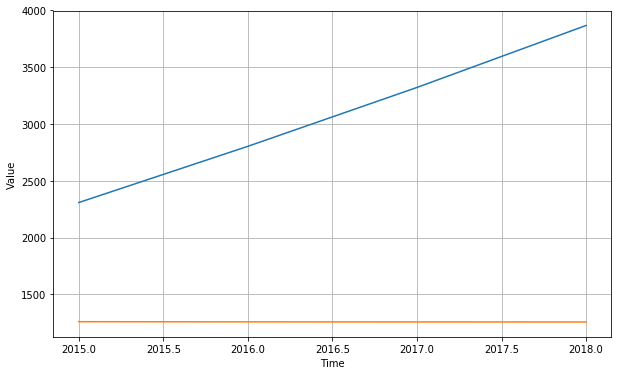

In [25]:
# Draw the prediction
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [26]:
# Define Error
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1817.7888

So, we see that error is too high. This model is worse than the model with 2 Dense layers

# 6. Use the model for the prediction

In [27]:
# Load the model 
model_f = tf.keras.models.load_model("2_Dense.model")

In [28]:
# Prediction for 2019 year
prediction_2019 = model_forecast(model_f, ts, window_size)[:, 0][-1]
prediction_2019

4442.128

In [29]:
# Add predicted data to the dataset
prediction_2019 = pd.Series(prediction_2019, index=[11])
ts = ts.append(prediction_2019)

In [30]:
# Prediction for 2020
prediction_2020 = model_forecast(model_f, ts, window_size)[:, 0][-1]
prediction_2020

5106.323

# Conclusion

According to our model, Income from selling cigarettes will be 5106 billions, it's 5.106 Trillions USD in 2020 year 